In [1]:
# Song Sentiment Analysis (SA) 
#
# SA carried out by Lexicon-based SA (LSA) on Bag-Of-Words (BOW) features, 
# utilizing Wu-Palmer Similarity (WPS)

import string
import glob
import re
import nltk
import random
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.cross_validation import cross_val_score

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
stop_words = set(stopwords.words('english'))
port = PorterStemmer()

In [3]:
# Dataset file lists, 4 total, one for each emotion

# Train Data Ingestion
happy_filelist = glob.glob('./data/Happy/Train/happy*.txt')
angry_filelist = glob.glob('./data/Angry/Train/angry*.txt')
relaxed_filelist = glob.glob('./data/Relaxed/Train/relaxed*.txt')
sad_filelist = glob.glob('./data/Sad/Train/sad*.txt')

# Test Data Ingestion
happy_filelist2 = glob.glob('./data/Happy/Test/happy*.txt')
angry_filelist2 = glob.glob('./data/Angry/Test/angry*.txt')
relaxed_filelist2 = glob.glob('./data/Relaxed/Test/relaxed*.txt')
sad_filelist2 = glob.glob('./data/Sad/Test/sad*.txt')

# Combine Train and Test Data For the Lexicon-Based Analysis
happy_filelist = happy_filelist + happy_filelist2
angry_filelist = angry_filelist + angry_filelist2
relaxed_filelist = relaxed_filelist + relaxed_filelist2
sad_filelist = sad_filelist + sad_filelist2

In [4]:
# read() function returns:
# lyrics(text tokenized, and lowercased without stopwords per song) and
# all_words(the lyrics output of all the songs as one list)
# based on the input of a file list and emotion tag

def read(filelist, tag):
    lyrics = []
    all_words = []
    
    for f in filelist:
        try:
            with open(f,'r') as file:
                song = file.read()
                file.close()
                #added
                #song = song.decode("utf-8-sig")
                song = re.sub(r"(\\n|\\u....|\t)", "", song)
                song = re.sub(r"(\[\d\d:\d\d\.\d\d\])","",song)
                song = song.lower()
                #song = nltk.word_tokenize(song)
                song = nltk.word_tokenize(song.translate(str.maketrans('','',string.punctuation)))
                song = [w for w in song if not w in string.punctuation]
                song = [w for w in song if not w in stop_words]
                song = [w for w in song if w != "'"]
                #song = [w for w in song if not "\ufeff" in w]
                #song = [w for w in song if w != "'"]
                song_tag = (song, tag)
                lyrics.append(song_tag)
                
                for word in song:
                    all_words.append(word)
        except:
            break
    return lyrics, all_words

In [5]:
# This function finds the features for a song

def find_features(song):
    words = set(song)
    features = {}
    for w in word_features:
        features[w] = (w in words)

    return features

In [6]:
# Create lyrics list for the 4 emotions seperately, 
# the entire lyric database, and all_words(a single list of all lyric tokens)

happy_lyrics, happy_words = read(happy_filelist, 'happy')
angry_lyrics, angry_words = read(angry_filelist, 'angry')
relaxed_lyrics, relaxed_words = read(relaxed_filelist, 'relaxed')
sad_lyrics, sad_words = read(sad_filelist, 'sad')

# Create "data" for testing
data = happy_lyrics + angry_lyrics + relaxed_lyrics + sad_lyrics
all_words = happy_words + angry_words + relaxed_words + sad_words

all_words = nltk.FreqDist(all_words)
word_features = list(all_words.keys())[:100] #i changed this to 25 from 100

In [7]:
# Create additional testing data
random.shuffle(data)
featuresets = [(find_features(song), tag) for (song, tag) in data]
train_set = featuresets[:680]
test_set = featuresets[681:]

In [8]:
# LSA BOW WPS

# Classifies the emotion of song lyrics based on the similarity of lyrics
# and that class's lexicon.  The lexicon is created with the seed word of 
# the class and is increased in size with synonyms.  Each word in a given
# song lyric is compared to each emotion synonym in the class and the sum
# is taken.  This sum of emotion similarity is calculated for all 4 emotions
# for each test data song.  The maximum of the 4 is chosen as the class
# label for that song. Uses wordnet to build the lexicons.



# Find synonyms of the four class emotions (in bag of words format)
from nltk.corpus import wordnet as wn

# Relaxed
synonymsR = []
for syn in wn.synsets("relaxed"):
    for l in syn.lemmas():
        synonymsR.append(l.name())

# Relaxed: adding words to increase the lexicon size
for syn in wn.synsets("calm"):
    for l in syn.lemmas():
        synonymsR.append(l.name())

        
# Happy
synonymsH = []
for syn in wn.synsets("happy"):
    for l in syn.lemmas():
        synonymsH.append(l.name())

# Happy: adding "pleasant" to increase the lexicon size
for syn in wn.synsets("pleasant"):
    for l in syn.lemmas():
        synonymsH.append(l.name())

# Happy: adding "laugh" to increase the lexicon size
for syn in wn.synsets("laugh"):
    for l in syn.lemmas():
        synonymsH.append(l.name())
        
# Sad
synonymsS = []
for syn in wn.synsets("sad"):
    for l in syn.lemmas():
        synonymsS.append(l.name())

# adding words to Sad Lexicon to increase size
for syn in wn.synsets("lonely"):
    for l in syn.lemmas():
        synonymsS.append(l.name())


# Angry
synonymsA = []
for syn in wn.synsets("angry"):
    for l in syn.lemmas():
        synonymsA.append(l.name())

# Angry: adding words to increase the lexicon
for syn in wn.synsets("hate"):
    for l in syn.lemmas():
        synonymsA.append(l.name())

for syn in wn.synsets("kill"):
    for l in syn.lemmas():
        synonymsA.append(l.name())

#synonymsA[0] # gives the 1st element in the list

# Get unique values only
synonymsA = set(synonymsA) 
synonymsR = set(synonymsR)
synonymsH = set(synonymsH)
synonymsS = set(synonymsS)

# Convert sets back to lists
synonymsA = list(synonymsA) 
synonymsR = list(synonymsR)
synonymsH = list(synonymsH)
synonymsS = list(synonymsS)


#synonymsH[0]
print(synonymsH)
print(synonymsR)
print(synonymsS)
print(synonymsA)

['jape', 'glad', 'gag', 'happy', 'jest', 'express_mirth', 'felicitous', 'express_joy', 'joke', 'pleasant', 'well-chosen', 'laughter', 'laugh']
['loose', 'calmness', 'simmer_down', 'tranquillize', 'quieten', 'relax', 'cool_off', 'calm_down', 'steady', 'unstrain', 'calm', 'slack_up', 'equanimity', 'relaxed', 'composure', 'slack', 'becalm', 'slacken', 'serene', 'make_relaxed', 'tranquil', 'calm_air', 'slow_down', 'decompress', 'lull', 'tranquilize', 'sedate', 'loosen', 'chill_out', 'loosen_up', 'quiet', 'tranquillise', 'unwind', 'cool_it', 'unagitated', 'still', 'settle_down', 'unlax', 'unbend']
['lonely', 'sorry', 'lamentable', 'distressing', 'lonesome', 'sad', 'deplorable', 'solitary', 'alone', 'unfrequented', 'pitiful', 'lone']
['vote_down', 'drink_down', 'shoot_down', 'down', 'furious', 'belt_down', 'wild', 'obliterate', 'killing', 'pour_down', 'tempestuous', 'hatred', 'pop', 'angry', 'kill', 'stamp_out', 'detest', 'toss_off', 'putting_to_death', 'bolt_down', 'hate', 'defeat', 'vote_o

In [9]:
# Specify the data that we will use to test the LSA
testdata = data  #testdata[1][1] # Returns the pre-determined label for the song

In [10]:
# Create a dataframe to store the test data's emotions similarity sum 
# scores for each of the four emotions. Rows = songs and 4 cols = emotion, one is for max class label 
# similarity sums. df#rows = #rows in the test data.

import pandas, numpy
df1 = pandas.DataFrame(index=np.arange(len(testdata)), columns = ['happy', 'relaxed', 'sad', 'angry', 'MaxClass', 'ActualClass'])

In [11]:
# this is the class label: testdata[songIndex][1]
# need to add this to the matrix for each index of testdata[index][1] at df1[index, 5]
  
# add "actual" class labels to the matrix for each song
for songIndex in range(len(testdata)):
    df1.iloc[songIndex, 5] = testdata[songIndex][1]

#df1

In [12]:
# Compare each lyric word in a song to every word in the Synonym list 
#  for each emotion

# HAPPY COLUMN CALCULATIONS

#this loop will assess every song
songind = 0  #j will be used as the row value for inputting sim sums into the df

x = len(testdata)  #number of items in the test set

#loop through every song:
for i in range(x):
    #songind+=1
    firstsong = testdata[songind][0]

    sum = 0  # initialize the sum value, per song, per emotion. If the simw1w2 is not 0, i.e. not "None", we want to keep track of it

    for w in firstsong:
        #if w1 is not null, then we do the rest of this cell....
        if wn.synsets(w):
            w1 = wn.synsets(w)[0]
            #print('w1')
            #print(w1)
            # For each of the synonyms
            for j in range(len(synonymsH)):
                w2 = synonymsH[j]
                w2 = wn.synsets(w2)[0]
                #print('w2')
                #print(w2)
                w1w2sim = w1.wup_similarity(w2)
                #print(w1w2sim)
                if w1w2sim != None:
                    #if w1w2sim > 0.7:
                    sum += w1w2sim
                    sum = sum / len(synonymsH) #normalize the sum by dividing by the number of synonymns
                    sum = sum / len(firstsong) #normalize the sum by dividing by the number of words in the song
                        #print('sum')
                        #print(sum)   # this is the sum for the first song's happy similarities
    df1.iloc[songind,0] = sum
    songind += 1

In [13]:
# RELAXED CALCULATIONS

#this loop will assess every song
songind = 0  #j will be used as the row value for inputting sim sums into the df

for i in range(x):
    #songind+=1
    firstsong = testdata[songind][0]

    sum = 0  # initialize the sum value, per song, per emotion. If the simw1w2 is not 0, i.e. not "None", we want to keep track of it

    for w in firstsong:
        #if w1 is not null, then we do the rest of this cell....
        if wn.synsets(w):
            w1 = wn.synsets(w)[0]
            #print('w1')
            #print(w1)
            # For each of the synonyms of Relaxed
            for j in range(len(synonymsR)):
                w2 = synonymsR[j]
                w2 = wn.synsets(w2)[0]
                #print('w2')
                #print(w2)
                w1w2sim = w1.wup_similarity(w2)
                #print(w1w2sim)
                if w1w2sim != None:
                    #if w1w2sim > 0.7:
                    sum += w1w2sim
                    sum = sum / len(synonymsR) #normalize the sum by dividing by the number of synonymns
                    sum = sum / len(firstsong) #normalize the sum by dividing by the number of words in the song
                        #print('sum')
                        #print(sum)   # this is the sum for the first song's Relaxed similarities
    df1.iloc[songind,1] = sum
    songind += 1

In [14]:
# SAD CALCULATIONS

#this loop will assess every song
songind = 0  #j will be used as the row value for inputting sim sums into the df

for i in range(x):
    #songind+=1
    firstsong = testdata[songind][0]

    sum = 0  # initialize the sum value, per song, per emotion. If the simw1w2 is not 0, i.e. not "None", we want to keep track of it

    for w in firstsong:
        #if w1 is not null, then we do the rest of this cell....
        if wn.synsets(w):
            w1 = wn.synsets(w)[0]
            #print('w1')
            #print(w1)
            # For each of the synonyms of Sad
            for j in range(len(synonymsS)):
                w2 = synonymsS[j]
                w2 = wn.synsets(w2)[0]
                #print('w2')
                #print(w2)
                w1w2sim = w1.wup_similarity(w2)
                #print(w1w2sim)
                if w1w2sim != None:
                    #if w1w2sim > 0.7:
                    sum += w1w2sim
                    sum = sum / len(synonymsS) #normalize the sum by dividing by the number of synonymns
                    sum = sum / len(firstsong) #normalize the sum by dividing by the number of words in the song
                        #print('sum')
                        #print(sum)   # this is the sum for the first song's Sad similarities
    df1.iloc[songind,2] = sum
    songind += 1

In [15]:
# ANGRY CALCULATIONS

#this loop will assess every song
songind = 0  #j will be used as the row value for inputting sim sums into the df

x = len(testdata)
for i in range(x):
    #songind+=1
    firstsong = testdata[songind][0]

    sum = 0  # initialize the sum value, per song, per emotion. If the simw1w2 is not 0, i.e. not "None", we want to keep track of it

    for w in firstsong:
        #if w1 is not null, then we do the rest of this cell....
        if wn.synsets(w):
            w1 = wn.synsets(w)[0]
            #print('w1')
            #print(w1)
            # For each of the synonyms of Angry
            for j in range(len(synonymsA)):
                w2 = synonymsA[j]
                w2 = wn.synsets(w2)[0]
                #print('w2')
                #print(w2)
                w1w2sim = w1.wup_similarity(w2)
                #print(w1w2sim)
                if w1w2sim != None:
                    #if w1w2sim > 0.7:
                    sum += w1w2sim
                    sum = sum / len(synonymsA) #normalize the sum by dividing by the number of synonymns
                    sum = sum / len(firstsong) #normalize the sum by dividing by the number of words in the song
                        #print('sum')
                        #print(sum)   # this is the sum for the first song's Angry similarities
    df1.iloc[songind,3] = sum
    songind += 1

In [16]:
# Find the max similarity value of each row and assign the class of that
# value as the Maximum Class Output class label

indx = 0

for i in range(x):
    #print(df1.iloc[indx].argmax())
    df1.iloc[indx, 4] = df1.iloc[indx, 0:4].argmax()
    #df1.iloc[indx, 4] = df1.iloc[indx].argmax()
    
    indx += 1

In [17]:
df1.iloc[0:10,:]  #Showing a portion of df1: the final collection of calculations and predictions

,happy,relaxed,sad,angry,MaxClass,ActualClass
0,0.00020749,2.84646e-05,0.000295043,0.000100686,sad,sad
1,5.26177e-05,4.38343e-05,5.03171e-05,2.56463e-05,happy,happy
2,0.000175932,2.41372e-05,0.000166904,0.000170694,happy,happy
3,0.000209468,6.10633e-05,0.00019857,0.000101626,happy,relaxed
4,0.000113533,0.000121032,0.000105533,5.44781e-05,relaxed,sad
5,0.000154107,2.20047e-05,0.000300451,7.592e-05,sad,sad
6,0.000233304,3.23835e-05,0.000223056,0.000284143,angry,happy
7,0.00021692,0.00010322,0.000470035,0.000125301,sad,sad
8,0.000267523,0.000142551,0.00024842,0.000128312,happy,sad
9,0.000158203,2.17057e-05,0.000149928,7.67607e-05,happy,angry


In [18]:
# Calculate Precision and Recall for each class

from pandas_ml import ConfusionMatrix

preds = list(df1.iloc[:, 4])    #predicted class labels to feed into the confusion matrix
actuals = list(df1.iloc[:, 5])  #actual class labels

cm = ConfusionMatrix(actuals, preds)
cm.print_stats()

Confusion Matrix:

Predicted  angry  happy  relaxed  sad  __all__
Actual                                        
angry          9     92       18   53      172
happy          7    134       18   47      206
relaxed        2    116       18   65      201
sad           13    106       16   64      199
__all__       31    448       70  229      778


Overall Statistics:

Accuracy: 0.289203084833
95% CI: (0.25755101889011817, 0.32246207285664918)
No Information Rate: ToDo
P-Value [Acc > NIR]: 1.0
Kappa: 0.0397055508311
Mcnemar's Test P-Value: ToDo


Class Statistics:

Classes                                    angry      happy      relaxed  \
Population                                   778        778          778   
P: Condition positive                        172        206          201   
N: Condition negative                        606        572          577   
Test outcome positive                         31        448           70   
Test outcome negative                        747 

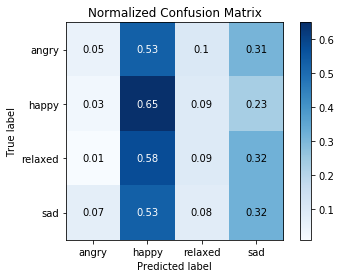

In [19]:
# Plot the resulting confusion matrix

import matplotlib.pyplot as plt
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(actuals, preds, normalize=True)
plt.show()